## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Introducción a las redes neuronales

## Actividad 2

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)



En esta actividad vamos a estudiar una primera aproximación a los modelos de redes neuronales, utilizando como base el modelo de regresión logística.


**Presentado por:**

* *Alexander Camargo Cód. 200911325*
* *Wilson González Cód. 200924943* 

In [ ]:
# Algunos paquetes iniciales que vamos a utilizar
import pandas as pd
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

## 1. Problema de clasificación: riesgo de default

Examinemos los datos con lo cuales ya estamos familiarizados:


https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

In [ ]:
credit_1 = pd.read_csv("germancredit.csv")
credit_1 = pd.get_dummies(credit_1, columns=['checkingstatus1','history','purpose','savings',
                                   'employ','status','others','property','otherplans','housing','job','tele', 
                                   'foreign'], prefix = ['checkingstatus1','history','purpose','savings',
                                   'employ','status','others','property','otherplans','housing','job','tele', 
                                   'foreign'])
X = credit_1.iloc[:, 1:62]
Y = credit_1.iloc[:, 0]


In [ ]:
CE_x, CP_x, CE_y, CP_y = model_selection.train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y)
print("Tamaño de CE, CP: ", CE_y.shape, CP_y.shape)
print("Observaciones de la clase positiva en entrenamiento: " +str(sum(CE_y)) +" y en prueba: " +str(sum(CP_y)))

Tamaño de CE, CP:  (600,) (400,)
Observaciones de la clase positiva en entrenamiento: 180 y en prueba: 120


## 2. Construcción de una neurona Sigmoide

Una neurona Sigmoide puede ser vista como un perceptrón *suavizado* que recibe una señal y entonces se activa. Al activarse, transforma la señal para entender mejor el mensaje. Esta transformación la ejecuta a partir de la fucnión Sigmoide.

Si tomamos la señal como un conjunto de datos de entrada y el mensaje como la predicción de un valor, la función de activación jugará el papel de transformadora de los datos de entrada en aquello que se quiere entender/predecir, que además replica un modelo logit con la función de activación sigmoide.

A continuación construiremos un clasificador de regresión logística bajo la perspectiva de una red neuronal, estudiando la arquitectura general de un algoritmo de aprendizaje. De esta manera, necesitaremos incluir la inicialización de los parámetros, el cálculo de la función de coste y su gradiente, y utilizar un algoritmo de optimización como por ejemplo el descenso en la dirección del gradiente (GD)

**Formulación del algoritmo**:

Para un ejemplo $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoide(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

El coste se calcula sumando sobre todos los ejemplos de entrenamiento:
$$ L = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$



### Construimos las partes del algoritmo  

- Inicializar los parámetros del modelo
- Bucle:
    - Calcular la pérdida actual (propagación hacia delante)
    - Calcular el gradiente actual (retro-propagación)
    - Actualizar los parámetros (descenso en la dirección del gradiente)


### Ejercicio 2.1
Implemente la funcion `sigmoide()` $$\sigma( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$$ Para ello puede utilizar np.exp().

In [ ]:
def sigmoide(z):
    """
    Input:
    z: Un escalar o arreglo numpy de cualquier tamaño
    Output:
    s: sigmoid(z)
    """

    s = 1/(1+np.exp(-z))
    
    return s

In [ ]:
print ("sigmoide([99,1,0,-1,-99]) = " + str(sigmoide(np.array([99,1,0,-1,-99]))))

sigmoide([99,1,0,-1,-99]) = [1.00000000e+00 7.31058579e-01 5.00000000e-01 2.68941421e-01
 1.01122149e-43]


**Salida esperada**: 

<table>
<tr>
<td> sigmoide([99,1,0,-1,-99])    = </td>
<td> [ 1.00000000e+00 7.31058579e-01 5.00000000e-01 2.68941421e-01
 1.01122149e-43] </td> 
</tr>
</table>

### Ejercicio 2.2 

Debemos inicializar los parámetros a cero. Puede utilizar la funcion np.zeros(), apoyandose en la documentación de la biblioteca Numpy.

In [ ]:
def inicializa_ceros(dim):
    """
    Esta función crea un vector de ceros de dimensión (dim, 1) para w e inicializa b a 0.
    Input:
    dim: tamaño del vector w (número de parámetros para este caso)
    Output:
    w: vector inicializado de tamaño (dim, 1)
    b: escalar inicializado (corresponde con el sesgo)
    """
    
    w = np.zeros([dim,1])

In [ ]:
dim = 6
w, b = inicializa_ceros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
b = 0


**Salida esperada**: 


<table style="width:35%">
<tr>
<td>   w   </td>
<td> [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] </td>
</tr>
<tr>
<td>   b   </td>
<td> 0 </td>
</tr>
</table>

### Ejercicio 2.3 
#### Propagación hacia delante y hacia atrás

Una vez los estimadores están inicializados, se pueden implementar los pasos de propagación hacia "delante" y hacia "atrás" para el aprendizaje automático. 

La propagación hacia delante consiste en calcular la función de activación sigmoide sobre la combinacón lineal de los patrones y los coeficientes inciales. 

Luego la propagación hacia atrás, o *retro-propagación*, es el paso más importante, donde utilizamos el gradiente de la función del error o de pérdida para actualizar los coeficientes. 

Este procedimiento se repite iterativamente replicando el procediemiento de descenso en la dirección del gradiente o *Gradient Descent* (GD).

A continuación implemente la función `propaga()` que calcula la función de coste y su gradiente.

**Ayuda**:

Propagación hacia delante:
- Se tiene $X$
- Se calcula $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Se calcula la función de coste/pérdida: $L = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Para la retro-propagación, tenemos que calcular la derivada parcial de *L* con respecto a nuestros coeficientes $(w,b)$:  

$$ \frac{\partial L}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$$
$$ \frac{\partial L}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$$

*Nota:* Para el cálculo de estas derivadas debemos hacer uso de la regla de la cadena. 

Esto es, dado $Z=w^T X + b$, se tiene que $$\frac{\partial L}{\partial Z} = \frac{\partial L}{\partial A} \frac{\partial A}{\partial Z} = \bigg(\frac{-Y}{A}+\frac{1-Y}{1-A}\bigg) (A \cdot (1-A)) $$


In [ ]:
def propaga(w, b, X, Y):
    """
    Implemente la función de coste y su gradiente para la propagación
    Input:
    w: pesos, un arreglo numpy 
    b: sesgo, un escalar
    X: datos de entrada
    Y: vector de etiquetas 
    Output:
    coste: coste negativo de log-verosimilitud para la regresión logística
    dw: gradiente de la pérdida con respecto a w, con las mismas dimensiones que w
    db: gradiente de la pérdida con respecto a b, con las mismas dimensiones que b
    
    (Sugerencia: utilice las funciones np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    A = sigmoide(np.dot(w.T, X) + b)                    # compute la activación
    coste = -(1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))                # compute el coste

    dw = (1/m)*np.dot(X,(A-Y).T) 
    db = (1/m)*np.sum(A-Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    coste = np.squeeze(coste)
    assert(coste.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, coste

In [ ]:
w, b, X, Y = np.array([[0.1],[0.1]]), 0.5, np.array([[66.,99.,-33.],[32.,55.,-2.1]]), np.array([[0,0,1]])
grads, coste = propaga(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("coste = " + str(coste))

dw = [[65.48251839]
 [29.66675568]]
db = 0.348980796447886
coste = 9.752716367426284


**Salida esperada**: 

<table style="width:50%">
<tr>
<td>   dw   </td>
<td> [[65.48251839]
 [29.66675568]]</td>
</tr>
<tr>
<td>   db   </td>
<td> 0.348980796447886 </td>
</tr>
<tr>
<td>   cost   </td>
<td> 9.752716367426284 </td>
</tr>
</table>

### Ejercicio 2.4 
#### Optimización

- Se tienen los parámetros inicializados.
- También se tiene el código para calcular la función de coste y su gradiente.
- Ahora se quieren actualizar los parámetros utilizando el GD.

Escriba la función de optimización para aprender $w$ y $b$ minimizando la función de coste $L$. 

Para un parámetro $\theta$, la regla de actualización es $ \theta = \theta - \alpha \text{ } d\theta$, donde $\alpha$ es la tasa de aprendizaje.

In [ ]:
def optimiza(w, b, X, Y, num_iter, tasa, print_cost):
    """
    Esta función optimiza w y b implementando el algoritmo de GD
    Input:
    w: pesos, un arreglo numpy 
    b: sesgo, un escalar
    X: datos de entrada
    Y: vector de etiquetas 
    num_iter: número de iteracionespara el bucle de optimización
    tasa: tasa de aprendizaje para la regla de actualización del GD
    print_cost: True para imprimir la pérdida cada 100 iteraciones
    Output:
    params: diccionario con los pesos w y el sesgo b
    grads: diccionario con los gradientes de los pesos y el sesgo con respecto a la función de pérdida
    costes: lista de todos los costes calculados durante la optimización, usados para graficar la curva de aprendizaje.
    
    Sugerencia: puede escribir dos pasos e iterar sobre ellos:
        1) Calcule el coste y el gradiente de los parámetros actuales. Use propaga().
        2) Actualize los parámetros usando la regla del GD para w y b.
    """
    
    costes = []
    
    for i in range(num_iter):
        
        
        # Computación del coste y el gradiente 
        grads, coste = propaga(w, b, X, Y)
        
        # Recupere las derivadas de grads
        dw = grads["dw"]
        db = grads["db"]
        
        # Actualize la regla 
        w = w - tasa * dw
        b = b - tasa * db
        
        # Guarde los costes
        if i % 100 == 0:
            costes.append(coste)
        
        # Se muestra el coste cada 100 iteraciones de entrenamiento
        if print_cost and i % 100 == 0:
            print ("Coste tras la iteración %i: %f" %(i, coste))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costes

In [ ]:
params, grads, costes = optimiza(w, b, X, Y, num_iter= 10, tasa = 0.001, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[-0.07262234]
 [ 0.02112647]]
b = 0.49898148713402446
dw = [[1.42076721]
 [0.43496446]]
db = -0.007821662502973652


**Salida esperada**:  

<table style="width:40%">
<tr>
<td> w </td>
<td>[[-0.07262234]
 [ 0.02112647]] </td>
</tr>
<tr>
<td> b </td>
<td> 0.49898148713402446 </td>
</tr>
<tr>
<td> dw </td>
<td> [[1.42076721]
 [0.43496446]] </td>
</tr>
<tr>
<td> db </td>
<td> -0.007821662502973652 </td>
</tr>
</table>

### Ejercicio 2.5

La función anterior aprende los parámetros w y b, que se pueden usar para predecir sobre el conjunto de datos X. 

Hay dos pasos para calcular las predicciones:

1. Calcular $\hat{Y} = A = \sigma(w^T X + b)$

2. Converir a 0 las entradas de $a$ (si la activación es <= 0.5) o 1 (si la activación es > 0.5), guarde las predicciones en un vector `Y_pred`.  

Ahora implemente la función `pred()`. 

In [ ]:
def pred(w, b, X):
    '''
    Prediga si una etiqueta es 0 o 1 usando los parámetros de regresión logística aprendidos (w, b)
    Input:
    w: pesos, un arreglo numpy 
    b: sesgo, un escalar
    X: datos de entrada
    Output:
    Y_pred: vector con todas las predicciones (0/1) para los ejemplos en X
    '''
    
    m = X.shape[1]
    Y_pred = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute el vector "A" prediciendo las probabilidades de que la imagen contenga un frailejon
    A = sigmoide(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        
        # Convierta las probabilidades A[0,i] a predicciones p[0,i]
        Y_pred[0,i] = round(A[0,i],0)
    
    assert(Y_pred.shape == (1, m))
    
    return Y_pred

In [ ]:
w = np.array([[0.12],[0.23]])
b = -0.09
X = np.array([[3.1,-2.9,0.2],[1.9,1.8,-0.09]])
print ("predicciones = " + str(pred(w, b, X)))

predicciones = [[1. 0. 0.]]


**Salida esperada**: 

<table style="width:40%">
<tr>
<td> predicciones   </td>
<td>[[ 1.  0.  0.]]  </td>  
</tr>
</table>

### Ejercicio 2.6
#### Combine todas las funciones 

Ahora juntemos todos los bloques que ha programado arriba.

Implemente la función del modelo "madre". Use la siguiente notación:
    - YP_pred para las predicciones sobre el conjunto de prueba
    - YE_pred para las predicciones sobre el conjunto de entrenamiento
    - w, costes, grads para las salidas de optimiza()

In [ ]:
def modelo(CE_x, CP_x, CE_y, CP_y, num_iter, tasa, print_cost):
    """
    Construye el modelo de regresión logística llamando las funciones implementadas anteriormente
    Output:
    d: diccionario con la información sobre el modelo.
    """
    
    # Inicialice los parametros con ceros 
    w, b = inicializa_ceros(CE_x.shape[0])

    # Descenso en la dirección del gradiente (GD) 
    params, grads, costes = optimiza(w, b, CE_x, CE_y, num_iter, tasa, print_cost)
    
    # Recupere los parámetros w y b del diccionario "params" ##
    w = params["w"]
    b = params["b"]
    
    # Prediga los ejemplos de prueba y entrenamiento (≈ 2 líneas de código)
    YP_pred = pred(w, b, CP_x)
    YE_pred = pred(w, b, CE_x)

    # Imprima los errores de entrenamiento y prueba
    print("Accuracy de entrenamiento: {} %".format(100 - np.mean(np.abs(YE_pred - CE_y)) * 100))
    print("Accuracy de prueba: {} %".format(100 - np.mean(np.abs(YP_pred - CP_y)) * 100))

    
    d = {"Costes": costes,
         "Prediccion_prueba": YP_pred, 
         "Prediccion_entrenamiento" : YE_pred, 
         "w" : w, 
         "b" : b,
         "Tasa de aprendizaje" : tasa,
         "Numero de iteraciones": num_iter}
    
    return d

### Pregunta 2.7

De qué dimensiones deben ser las matrices con los datos de entrada y de salida?

In [ ]:
# Podemos re-configurar las matrices de la siguiente forma:
CE_x2 = CE_x.T
CP_x2 = CP_x.T
CE_y2 = np.array(CE_y)[np.newaxis]
CP_y2 = np.array(CP_y)[np.newaxis]

print(CE_x2.shape, CE_y2.shape)

(61, 600) (1, 600)


Ahora, ejecute la siguiente celda para entrenar el modelo:

In [ ]:
d = modelo(CE_x2, CP_x2, CE_y2, CP_y2, num_iter = 1000, tasa = 1e-6, print_cost = True)

Coste tras la iteración 0: 0.693147
Coste tras la iteración 100: 0.678157
Coste tras la iteración 200: 0.677031
Coste tras la iteración 300: 0.675938
Coste tras la iteración 400: 0.674877
Coste tras la iteración 500: 0.673846
Coste tras la iteración 600: 0.672844
Coste tras la iteración 700: 0.671871
Coste tras la iteración 800: 0.670925
Coste tras la iteración 900: 0.670005
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %


**Salida esperada**: 

<table style="width:50%"> 
<tr>
<td> Coste tras la iteración 0   </td> 
<td> 0.693147 </td>
</tr>
<tr>
<td> <center> $\vdots$ </center> </td> 
<td> <center> $\vdots$ </center> </td> 
</tr>  
<tr>
<td> Precisión de entrenamiento  </td> 
<td> 70.0 % </td>
</tr>
<tr>
<td> Precisión de prueba </td> 
<td> 70.0 % </td>
</tr>
</table> 

La precisión de entrenamiento es muy similar a la que conseguimos mediante la regresion logistica. También podemos observar que el error de prueba es igual al de entrenamiento. Este resultado sugiere que el modelo aprende segun entrenamiento, y generaliza de igual forma sobre los observaciones nuevas.

Grafiquemos la función de pérdida.

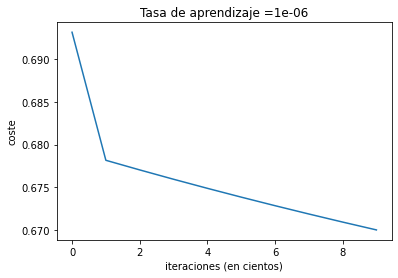

In [ ]:
# Gráfica de la curva de aprendizaje (con costes)
costes = np.squeeze(d['Costes'])
plt.plot(costes)
plt.ylabel('coste')
plt.xlabel('iteraciones (en cientos)')
plt.title("Tasa de aprendizaje =" + str(d["Tasa de aprendizaje"]))
plt.show()

**Interpretación**:
Se puede ver el coste decreciendo, demostrando que los parámetros están siendo aprendidos. 

Ya tenemos un primer modelo de clasificación. Ahora examinemos distintos valores para la tasa de aprendizaje $\alpha$. 

#### Selección de la tasa de aprendizaje ####

Para que el método del GD funcione de manera adecuada, se debe elegir la tasa de aprendiazaje de manera acertada. Esta tasa $\alpha$  determina qué tan rápido se actualizan los parámetros. Si la tasa es muy grande se puede "sobrepasar" el valor óptimo. Y de manera similar, si es muy pequeña se van a necesitar muchas iteraciones para converger a los mejores valores. Por ello la importancia de tener una tase de aprensizaje bien afinada.  

Ahora, comparemos la curva de aprendizaje de nuestro modelo con distintas elecciones para $\alpha$. Ejecute el código abajo. También puede intentar con valores distintos a los tres que estamos utilizando abajo para `tasas` y analize los resultados.



La tasa de aprendizaje es: 0.0001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


Accuracy de entrenamiento: 33.0 %
Accuracy de prueba: 32.75 %

-------------------------------------------------------

La tasa de aprendizaje es: 1e-06
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------

La tasa de aprendizaje es: 1e-10
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------

La tasa de aprendizaje es: 2e-20
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------



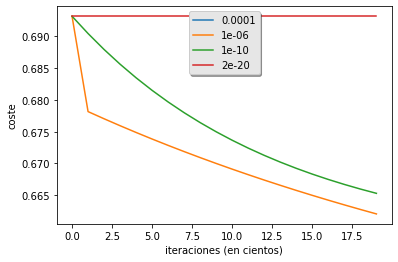

In [ ]:
tasas = [1e-4, 1e-6, 1e-10, 2e-20]
modelos = {}
for i in tasas:
    print ("La tasa de aprendizaje es: " + str(i))
    modelos[str(i)] = modelo(CE_x2, CP_x2, CE_y2, CP_y2, num_iter = 2000, tasa = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in tasas:
    plt.plot(np.squeeze(modelos[str(i)]["Costes"]), label= str(modelos[str(i)]["Tasa de aprendizaje"]))

plt.ylabel('coste')
plt.xlabel('iteraciones (en cientos)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

### Pregunta 2.8

Analice los resultados, con cuál tasa de aprendizaje intentaría mejorar el desempeño del modelo?

Se observa que la mejor tasa de aprendizaje es 1e-6. Esto podría pasar porque el número de iteraciones es muy bajo para las tasas más pequeñas. Sin embargo, tambien es probable que las tasas de aprendizaje sean muy pequeñas y no logren llegar a al optimo por no percibir grandes cambios la función objetivo.



## 3. Comparacion con la implementación tradicional de regresión logística

A continuación ajustamos el modelo logístico y lo probamos:

In [ ]:
logT = LogisticRegression(penalty='none', max_iter=1500)
logT.fit(CE_x, CE_y)
y_tr = logT.predict(CE_x)
y_pred = logT.predict(CP_x)

Examinemos los coeficientes del modelo de la neurona sigmoide y su desviación con respecto a la estimación tradicional de regresion logistica.

In [ ]:
from astropy.table import QTable, Table, Column

Tabla =  Table([logT.coef_.T, d['w'], CE_x.T], names=("Regresion logistica", "Neurona sigmoide", "Diferencia"))
Tabla

Regresion logistica [1],Neurona sigmoide [1],Diferencia [600]
float64,float64,int64
0.022896132865997627,-6.293083905403856e-05,18 .. 15
0.00010899827650279354,-1.631136907400603e-05,12976 .. 3029
0.3244034132126813,-0.00015135061139790666,3 .. 2
0.07379703610118447,-0.00016794413611101247,4 .. 2
-0.008265241352952623,-0.0023681544427456127,38 .. 33
0.2400698035951681,-8.574184624564529e-05,1 .. 1
0.19145797108504312,-6.586234732681293e-05,1 .. 1
0.5511262709951815,2.9167410750735905e-05,0 .. 0
0.1186436507074439,8.42971128730068e-06,1 .. 0


### Pregunta 3.1

Qué puede observar en esta comparativa?

#### Se puede observar que hay bastantes diferencias entre los dos modelos y sus coeficientes. 

Veamos la exactitud de los modelos

In [ ]:
print("La neurona sigmoide tiene una exactitud de entrenamiento: " 
      +str(float((d['Prediccion_entrenamiento'] == CE_y2).mean())) +" y de validacion: " +str(float((d['Prediccion_prueba'] == CP_y2).mean())))
print("La regresion tradicional tiene una exactitud de entrenamiento: " 
      +str(float((y_tr == CE_y).mean())) +" y de validacion: " +str(float((y_pred == CP_y).mean())))

La neurona sigmoide tiene una exactitud de entrenamiento: 0.7 y de validacion: 0.7
La regresion tradicional tiene una exactitud de entrenamiento: 0.785 y de validacion: 0.7575


### Ejercicio  3.2

Ahora puede desarrollar su propio código intentando mejorar los resultados obtenidos. 

Intente sobrepasar los resultados de la regresion logistica tradicional. Optimice la tasa de aprendizaje, el número de iteraciones o (bono) investigue y cambie la manera en la cual inicializamos los coeficientes. 

Numero de iteraciones es: 1000
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------

Numero de iteraciones es: 2500
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------

Numero de iteraciones es: 4500
Accuracy de entrenamiento: 70.16666666666666 %
Accuracy de prueba: 72.75 %

-------------------------------------------------------

Numero de iteraciones es: 5000
Accuracy de entrenamiento: 70.33333333333333 %
Accuracy de prueba: 71.75 %

-------------------------------------------------------



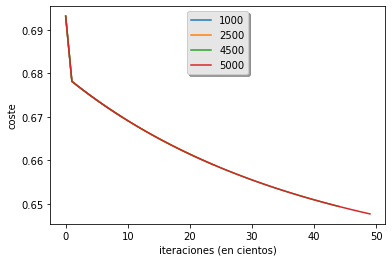

In [ ]:
itera = [1000, 2500, 4500, 5000]
modelos = {}
for i in itera:
    print ("Numero de iteraciones es: " + str(i))
    modelos[str(i)] = modelo(CE_x2, CP_x2, CE_y2, CP_y2, num_iter = i, tasa = 1e-6, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in itera:
    plt.plot(np.squeeze(modelos[str(i)]["Costes"]), label= str(modelos[str(i)]["Numero de iteraciones"]))

plt.ylabel('coste')
plt.xlabel('iteraciones (en cientos)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

Cambiando el número de iteraciones se logró mejorar el accuracy de la red, pero sigue sin tener mejores resultados que la regresion logistica. Intentaremos inicializando los w con valores aleatorios. 

In [ ]:
def inicializa_rand(dim):
    """
    Esta función crea un vector de ceros de dimensión (dim, 1) para w e inicializa b a 0.
    Input:
    dim: tamaño del vector w (número de parámetros para este caso)
    Output:
    w: vector inicializado de tamaño (dim, 1)
    b: escalar inicializado (corresponde con el sesgo)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    w = np.random.randn(dim,1)
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [ ]:
dim = 6
w, b = inicializa_rand(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[-0.41675785]
 [-0.05626683]
 [-2.1361961 ]
 [ 1.64027081]
 [-1.79343559]
 [-0.84174737]]
b = 0


In [ ]:
def modelo2(CE_x, CP_x, CE_y, CP_y, num_iter, tasa, print_cost):
    """
    Construye el modelo de regresión logística llamando las funciones implementadas anteriormente
    Output:
    d: diccionario con la información sobre el modelo.
    """
    
    # Inicialice los parametros con ceros 
    w, b = inicializa_rand(CE_x.shape[0])

    # Descenso en la dirección del gradiente (GD) 
    params, grads, costes = optimiza(w, b, CE_x, CE_y, num_iter, tasa, print_cost)
    
    # Recupere los parámetros w y b del diccionario "params" ##
    w = params["w"]
    b = params["b"]
    
    # Prediga los ejemplos de prueba y entrenamiento (≈ 2 líneas de código)
    YP_pred = pred(w, b, CP_x)
    YE_pred = pred(w, b, CE_x)

    # Imprima los errores de entrenamiento y prueba
    print("Accuracy de entrenamiento: {} %".format(100 - np.mean(np.abs(YE_pred - CE_y)) * 100))
    print("Accuracy de prueba: {} %".format(100 - np.mean(np.abs(YP_pred - CP_y)) * 100))

    
    d = {"Costes": costes,
         "Prediccion_prueba": YP_pred, 
         "Prediccion_entrenamiento" : YE_pred, 
         "w" : w, 
         "b" : b,
         "Tasa de aprendizaje" : tasa,
         "Numero de iteraciones": num_iter}
    
    return d

In [ ]:
tasas = [1e-4, 1e-6, 1e-10, 2e-20]
modelos = {}
for i in tasas:
    print ("La tasa de aprendizaje es: " + str(i))
    modelos[str(i)] = modelo2(CE_x2, CP_x2, CE_y2, CP_y2, num_iter = 4500, tasa = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

La tasa de aprendizaje es: 0.0001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


Accuracy de entrenamiento: 69.83333333333333 %
Accuracy de prueba: 70.75 %

-------------------------------------------------------

La tasa de aprendizaje es: 1e-06
Accuracy de entrenamiento: 66.66666666666667 %
Accuracy de prueba: 68.75 %

-------------------------------------------------------

La tasa de aprendizaje es: 1e-10
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------

La tasa de aprendizaje es: 2e-20
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------



Al cambiar la inicialización por un random no observamos mejoras. Esto puede pasar porque la funcion sigmoide tiene sus limites, y terner solo una hidden layer no permite predicciones más acertadas por parte de la red. Para mejorar los resulatdos se podría intentar con otras funciones de activación (tanh o ReLu) y/o agregar mas hidden layers a la red.
